# **1000-719bMSB Modeling of Complex Biological Systems**
# **Deep Neural Network: Unsupervised Learning**

# Variational Autoencoder on MNIST

VAEs are directed probabilistic graphical models (DPGM) whose posterior is approximated by a neural network, forming an autoencoder-like architecture. Unlike discriminative modeling that aims to learn a predictor given observation, generative modeling tries to learn how the data is generated, and to reflect the underlying causal relations. [...] Variational autoencoder models make strong assumptions concerning the distribution of latent variables. They use a variational approach for latent representation learning, which results in an additional loss component and a specific estimator for the training algorithm called the Stochastic Gradient Variational Bayes (SGVB) estimator. [Wikipedia](https://en.wikipedia.org/wiki/Autoencoder)

We build a VAE and train it on the MNIST dataset.  

In [1]:
import tensorflow as tf
%tensorflow_version 1.x
print(tf.__version__)
tf.compat.v1.disable_eager_execution() 

import keras
from keras import layers
from keras import backend as K
from keras.models import Model
from keras.datasets import mnist
import matplotlib.pyplot as plt
import numpy as np

img_shape = (28, 28, 1)
batch_size = 16
latent_dim = 2

TensorFlow is already loaded. Please restart the runtime to change versions.
2.4.1


In [2]:
#Define encoder network
#Note that we are using keras functional API
input_img = keras.Input(shape=img_shape)
x = layers.Conv2D(32, 3, padding='same', activation='relu')(input_img)
x = layers.Conv2D(64, 3, padding='same', activation='relu', strides=(2, 2))(x)
x = layers.Conv2D(64, 3, padding='same', activation='relu')(x)
x = layers.Conv2D(64, 3, padding='same', activation='relu')(x)

shape_before_flattening = K.int_shape(x)
x = layers.Flatten()(x)
x = layers.Dense(32, activation='relu')(x)
#x = layers.Dense(2, activation='relu')(x)

# it's the same!!!
z_mean = layers.Dense(latent_dim)(x)
z_log_var = layers.Dense(latent_dim)(x)

In [3]:
#Sampling from the distributions to obtain latent space
def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim),
    mean=0., stddev=1.)
    return z_mean + K.exp(z_log_var) * epsilon
z = layers.Lambda(sampling)([z_mean, z_log_var])

encoder = Model(input_img, z)

In [4]:
#Define decoder network
decoder_input = layers.Input(K.int_shape(z)[1:])
x = layers.Dense(np.prod(shape_before_flattening[1:]), activation='relu')(decoder_input)
x = layers.Reshape(shape_before_flattening[1:])(x)
x = layers.Conv2DTranspose(32, 3,padding='same', activation='relu', strides=(2, 2))(x)
x = layers.Conv2D(1, 3,padding='same', activation='sigmoid')(x)

decoder = Model(decoder_input, x)
z_decoded = decoder(z)

In [5]:
def vae_loss(input_img, z_decoded):
    input_img = K.flatten(input_img)
    z_decoded = K.flatten(z_decoded)
    xent_loss = keras.metrics.binary_crossentropy(input_img, z_decoded) 
    kl_loss = -5e-4 * K.mean(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
    return K.mean(xent_loss + kl_loss)

In [22]:
vae = Model(input_img, z_decoded)
vae.compile(optimizer='adam', loss=vae_loss)

In [23]:
vae.summary()
decoder.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 28, 28, 32)   320         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 14, 14, 64)   18496       conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 14, 14, 64)   36928       conv2d_1[0][0]                   
____________________________________________________________________________________________

In [8]:
#load the data and split into train + test sets
(x_train, _), (x_test, y_test) = mnist.load_data()

In [9]:
x_train = x_train.astype('float32') / 255.
x_train = x_train.reshape(x_train.shape + (1,))
x_test = x_test.astype('float32') / 255.
x_test = x_test.reshape(x_test.shape + (1,))

We are ready to train VAE on this dataset

**I trained VAE on larger batches and a little bit longer, because simpler model was pretty bad at prediction of 4s.**

In [24]:
vae.fit(x=x_train, y=x_train, shuffle=True, epochs=20, batch_size=128)

Train on 60000 samples
Epoch 1/20
60000/60000 [==============================] - 7s 116us/sample - loss: 0.1732
Epoch 2/20
60000/60000 [==============================] - 6s 105us/sample - loss: 0.1729
Epoch 3/20
60000/60000 [==============================] - 6s 104us/sample - loss: 0.1726
Epoch 4/20
60000/60000 [==============================] - 6s 105us/sample - loss: 0.1725
Epoch 5/20
60000/60000 [==============================] - 6s 105us/sample - loss: 0.1722
Epoch 6/20
60000/60000 [==============================] - 6s 106us/sample - loss: 0.1721
Epoch 7/20
60000/60000 [==============================] - 6s 106us/sample - loss: 0.1719
Epoch 8/20
60000/60000 [==============================] - 6s 105us/sample - loss: 0.1717
Epoch 9/20
60000/60000 [==============================] - 6s 104us/sample - loss: 0.1716
Epoch 10/20
60000/60000 [==============================] - 6s 105us/sample - loss: 0.1714
Epoch 11/20
60000/60000 [==============================] - 6s 104us/sample - loss: 0.1

In [12]:
# to save the trained VAE on Google Drive and load them later. Not necessary
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [13]:
vae.save_weights('drive/My Drive/Colab Notebooks/vae_weights.h5')
#vae.load_weights('drive/My Drive/Colab Notebooks/vae_weights.h5')

In [25]:
encoded = encoder.predict(x_test)
decoded = decoder.predict(encoded)

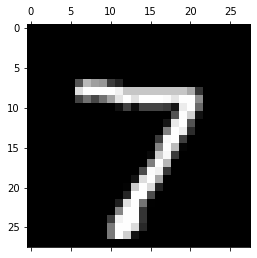

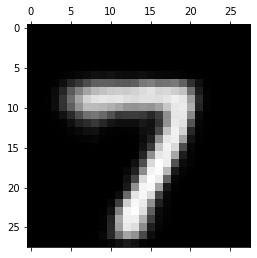

In [26]:
plt.matshow(x_test[0][:,:,0], cmap='gray')
plt.matshow(decoded[0][:,:,0], cmap='gray')

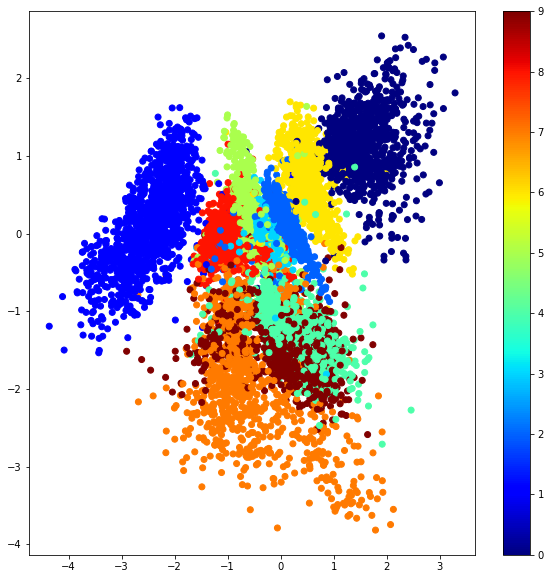

In [27]:
x_test_encoded = encoder.predict(x_test)
plt.figure(figsize=(10, 10))
plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1], c=y_test, cmap='jet')
plt.colorbar()
plt.show()

**HOMEWORK 3** 

Interpolate between two latent vectors (i.e., moving in the latent space) and decode and visualize the interpolations. Provide a code (python notebook) to do this interpolation; and provide 3 interpolated images in-between.

**As in presentation, moving from one number to another.**

In [28]:
def interpolate_between(x, idx1, idx2, encoder, decoder, n):
    """Interpolate between two images.

    Parameters
    ----------
    x : matrix
        Matrix with image data.
    idx1, idx2 : int
        Index of two chosen images. Interpolation will be done from one to 
        another.
    encoder : model
    decoder : model
    n : int
        Number of all images to generate.
    """
    image1, image2 = encoder.predict(np.array([x[idx1], x[idx2]]))


    mean_epsilon = np.linspace(min(image1[0], image2[0]), 
                              max(image1[0], image2[0]), 
                              n)
    var_epsilon = np.linspace(min(image1[1], image2[1]), 
                              max(image1[1], image2[1]), 
                              n)

    new_images = np.array(
        [[mean_epsilon[i], var_epsilon[i]] for i in range(n)]
        )
    decoded_images = decoder.predict(new_images)

    fig, axs = plt.subplots(1, 2)
    plt.suptitle('Original images', fontsize=20)
    axs[0].imshow(x[idx1, :, :, 0], cmap='gray')
    axs[1].imshow(x[idx2, :, :, 0], cmap='gray')
    plt.show()

    fig, axs = plt.subplots(1, n, figsize=(100, 10))
    plt.suptitle('Interpolation between images', fontsize=80)
    print()

    for i in range(15):
        axs[i].imshow(decoded_images[i, :, :, 0], cmap='gray')
        axs[i].set_axis_off()

    plt.show()

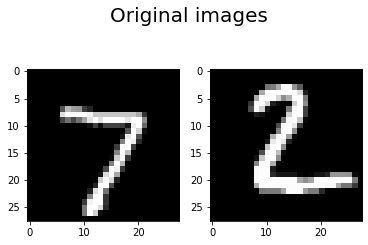

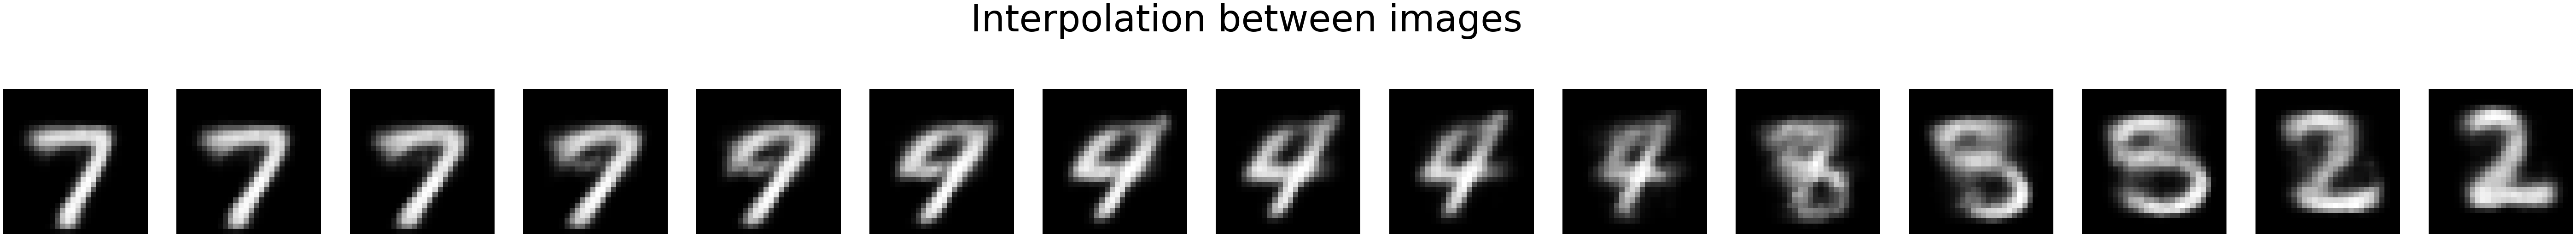

In [29]:
interpolate_between(x_test, 0, 1, encoder, decoder, 15)

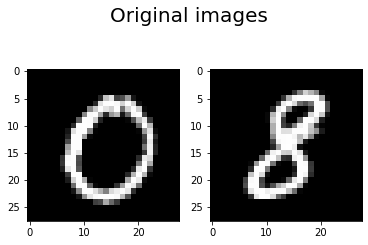

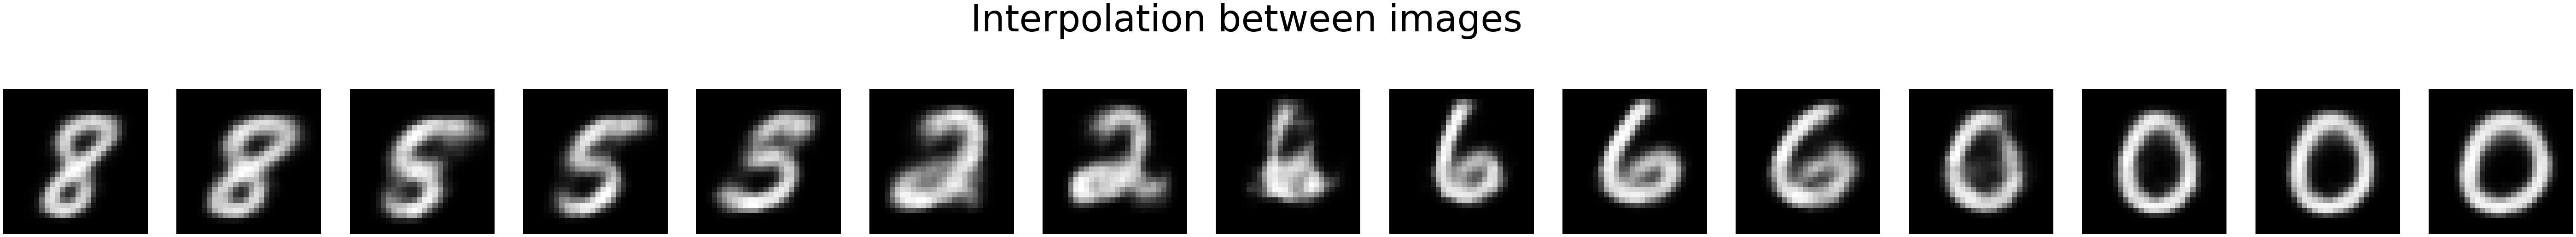

In [30]:
interpolate_between(x_test, 101, 110, encoder, decoder, 15)

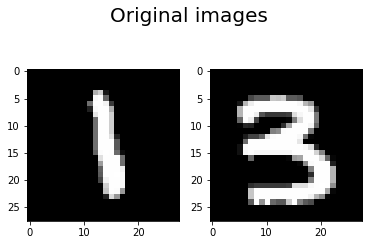

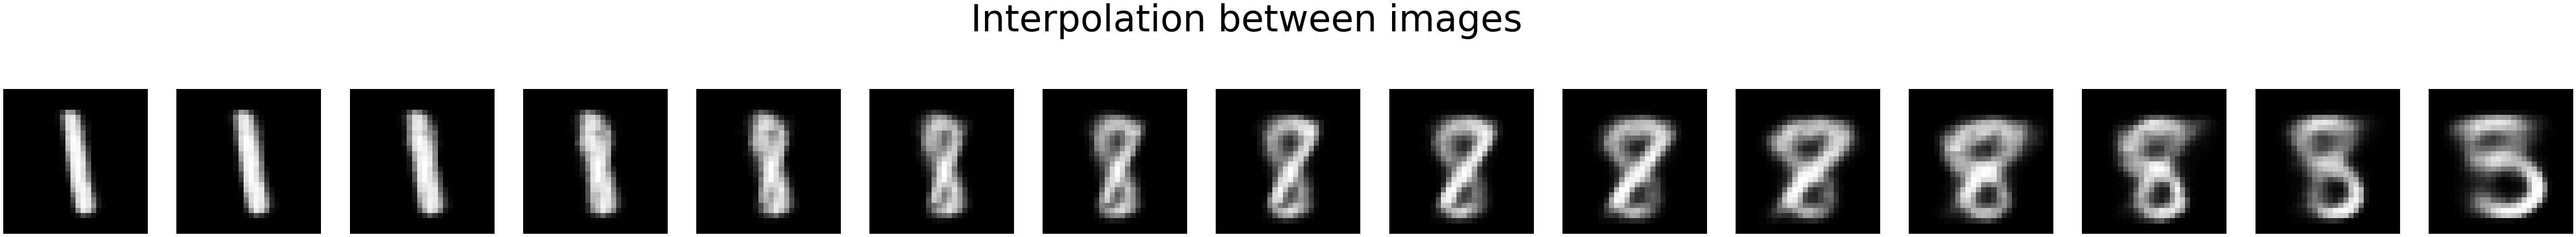

In [31]:
interpolate_between(x_test, 640, 648, encoder, decoder, 15)

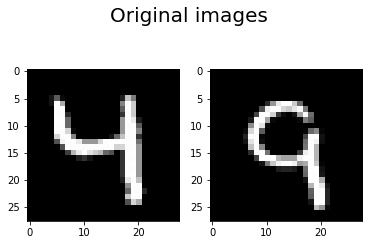

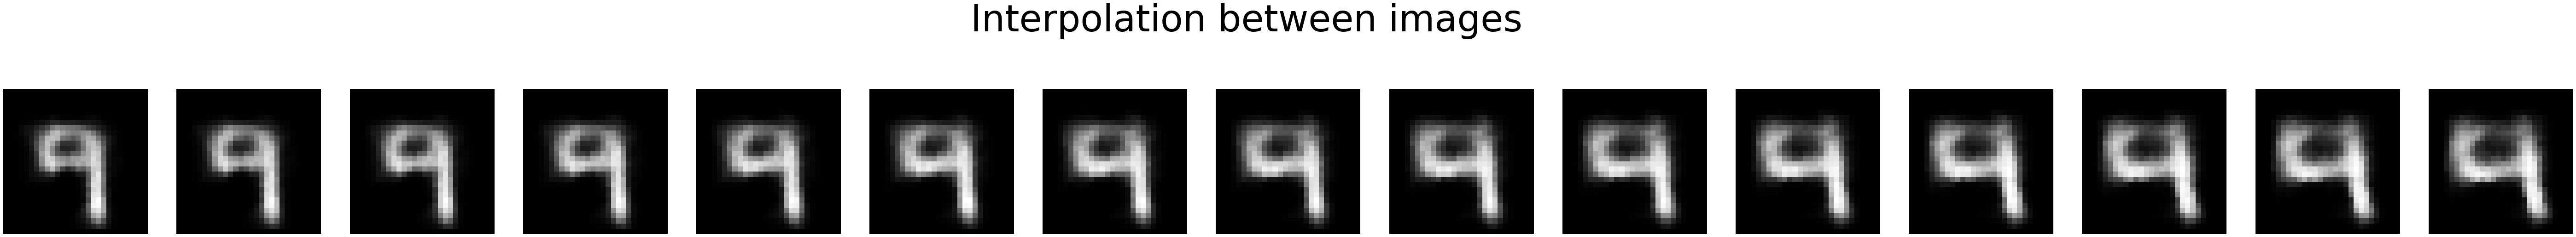

In [32]:
interpolate_between(x_test, 901, 913, encoder, decoder, 15)

**In the last two examples decoding of 3 and 4 was not ideal.**

# DeepDream

https://distill.pub/2018/building-blocks/

[Read the introduction to DeepDream](https://web.archive.org/web/20150703064823/http://googleresearch.blogspot.co.uk/2015/06/inceptionism-going-deeper-into-neural.html)

In [ ]:
from keras.applications import inception_v3
from keras import backend as K
#disable all training-specific options
K.set_learning_phase(0)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/backend.py:434: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn('`tf.keras.backend.set_learning_phase` is deprecated and '


In [ ]:
model = inception_v3.InceptionV3(weights='imagenet',
include_top=False)

87916544/87910968 [==============================] - 1s 0us/step


In [ ]:
model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv2d_5 (Conv2D)               (None, None, None, 3 864         input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, None, None, 3 96          conv2d_5[0][0]                   
__________________________________________________________________________________________________
activation (Activation)         (None, None, None, 3 0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [ ]:
#coefficients for contribution of selected layers
layer_contributions = {
'mixed2': 0.2,
'mixed3': 3.,
'mixed4': 2.,
'mixed5': 1.5,
}

In [ ]:
#Creates a dictionary that maps layer names to layer instances
layer_dict = dict([(layer.name, layer) for layer in model.layers])

In [ ]:
layer_dict['mixed2']

In [ ]:
#define the loss
loss = K.variable(0.)
for layer_name in layer_contributions:
    coeff = layer_contributions[layer_name]
    activation = layer_dict[layer_name].output
    scaling = K.prod(K.cast(K.shape(activation), 'float32'))
    #here the loss is the L2 norm of activations of whole layer 
    #before: only chosen filter
    loss = loss + coeff * K.sum(K.square(activation[:, 2: -2, 2: -2, :])) / scaling   

In [ ]:
#define gradient-ascent process

#this was before a noise image, now image of choice
dream = model.input

#gradient of loss wrt input image
grads = K.gradients(loss, dream)[0]
#normalize gradient
grads /= K.maximum(K.mean(K.abs(grads)), 1e-7)

outputs = [loss, grads]
fetch_loss_and_grads = K.function([dream], outputs)

def eval_loss_and_grads(x):
    outs = fetch_loss_and_grads([x])
    loss_value = outs[0]
    grad_values = outs[1]
    return loss_value, grad_values
    
def gradient_ascent(x, iterations, step, max_loss=None):
    for i in range(iterations):
        loss_value, grad_values = eval_loss_and_grads(x)
        if max_loss is not None and loss_value > max_loss:
            break
        print('...Loss value at', i, ':', loss_value)
        x = x + step * grad_values
    return x

In [ ]:
#define some auxilliary function
import scipy
from keras.preprocessing import image
import imageio
def resize_img(img, size):
    img = np.copy(img)
    factors = (1,
    float(size[0]) / img.shape[1],
    float(size[1]) / img.shape[2],
    1)
    return scipy.ndimage.zoom(img, factors, order=1)
def save_img(img, fname):
    pil_img = deprocess_image(np.copy(img))
    imageio.imwrite(fname, pil_img)
def preprocess_image(image_path):
    img = image.load_img(image_path, target_size=(400,400))
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = inception_v3.preprocess_input(img)
    return img
def deprocess_image(x):
    if K.image_data_format() == 'channels_first':
        x = x.reshape((3, x.shape[2], x.shape[3]))
        x = x.transpose((1, 2, 0))
    else:
        #undoes the preprocessing done by inception_v3.preprocess_input
        x = x.reshape((x.shape[1], x.shape[2], 3))
        x /= 2.
        x += 0.5
        x *= 255.
        x = np.clip(x, 0, 255).astype('uint8')
    return x

In [ ]:
base_image_path = 'drive/My Drive/dog_cat.jpeg'
img = preprocess_image(base_image_path)
iterations = 20
step = 0.01

img = gradient_ascent(img,
        iterations=iterations,
        step=step,
        max_loss=15.0)

...Loss value at 0 : 1.8649933
...Loss value at 1 : 2.3151162
...Loss value at 2 : 2.981555
...Loss value at 3 : 3.7449098
...Loss value at 4 : 4.5288196
...Loss value at 5 : 5.3213468
...Loss value at 6 : 6.0550776
...Loss value at 7 : 6.795658
...Loss value at 8 : 7.511652
...Loss value at 9 : 8.197695
...Loss value at 10 : 8.847527
...Loss value at 11 : 9.511219
...Loss value at 12 : 10.124952
...Loss value at 13 : 10.708273
...Loss value at 14 : 11.342343
...Loss value at 15 : 11.894577
...Loss value at 16 : 12.452756
...Loss value at 17 : 13.01758
...Loss value at 18 : 13.544574
...Loss value at 19 : 14.052682


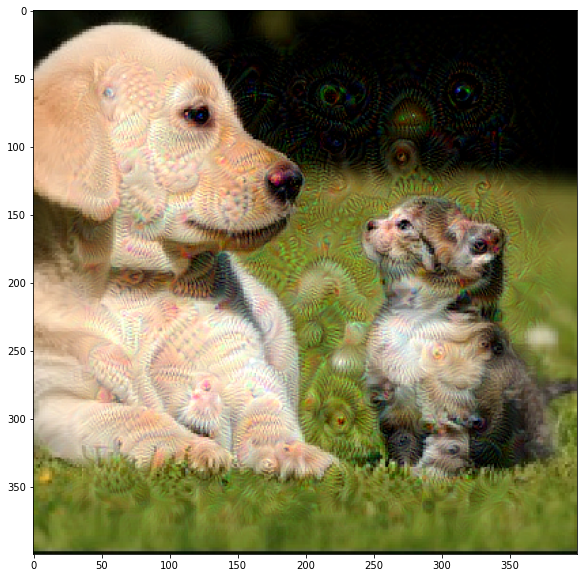

In [ ]:
plt.rcParams["figure.figsize"] = (10,10)
plt.imshow(deprocess_image(img))

In [ ]:
import numpy as np
step = 0.01
num_octave = 3
octave_scale = 1.4
iterations = 20
max_loss = 10.
base_image_path = 'drive/My Drive/dog_cat.jpeg'
img = preprocess_image(base_image_path)

In [ ]:
original_shape = img.shape[1:3]
successive_shapes = [original_shape]
for i in range(1, num_octave):
    shape = tuple([int(dim / (octave_scale ** i))
        for dim in original_shape])
    successive_shapes.append(shape)

successive_shapes = successive_shapes[::-1]
original_img = np.copy(img)
shrunk_original_img = resize_img(img, successive_shapes[0])

In [ ]:
successive_shapes

[(204, 204), (285, 285), (400, 400)]

In [ ]:
#to make the effect look cooler
for shape in successive_shapes:
    print('Processing image shape', shape)
    #upscale image and apply gradient descent
    img = resize_img(img, shape)
    img = gradient_ascent(img,
        iterations=iterations,
        step=step,
        max_loss=max_loss)
    
    #insert details lost by upscaling
    upscaled_shrunk_original_img = resize_img(shrunk_original_img, shape) #will be pixelated
    same_size_original = resize_img(original_img, shape)                  #high-quality image by downscaling original
    lost_detail = same_size_original - upscaled_shrunk_original_img       #detail that was lost when scaling up

    img = img + lost_detail #reinsert the detail
    shrunk_original_img = resize_img(original_img, shape)

Processing image shape (204, 204)
...Loss value at 0 : 1.6679993
...Loss value at 1 : 2.1739056
...Loss value at 2 : 2.7867906
...Loss value at 3 : 3.3931475
...Loss value at 4 : 3.9500625
...Loss value at 5 : 4.4797516
...Loss value at 6 : 5.074745
...Loss value at 7 : 5.616102
...Loss value at 8 : 6.165328
...Loss value at 9 : 6.648004
...Loss value at 10 : 7.120631
...Loss value at 11 : 7.491002
...Loss value at 12 : 7.976029
...Loss value at 13 : 8.437127
...Loss value at 14 : 8.845374
...Loss value at 15 : 9.207301
...Loss value at 16 : 9.625328
...Loss value at 17 : 9.976729
Processing image shape (285, 285)
...Loss value at 0 : 2.9546204
...Loss value at 1 : 4.347239
...Loss value at 2 : 5.4461718
...Loss value at 3 : 6.326284
...Loss value at 4 : 7.1115
...Loss value at 5 : 7.879013
...Loss value at 6 : 8.567653
...Loss value at 7 : 9.20353
...Loss value at 8 : 9.84967
Processing image shape (400, 400)
...Loss value at 0 : 3.0609865
...Loss value at 1 : 4.457088
...Loss value a

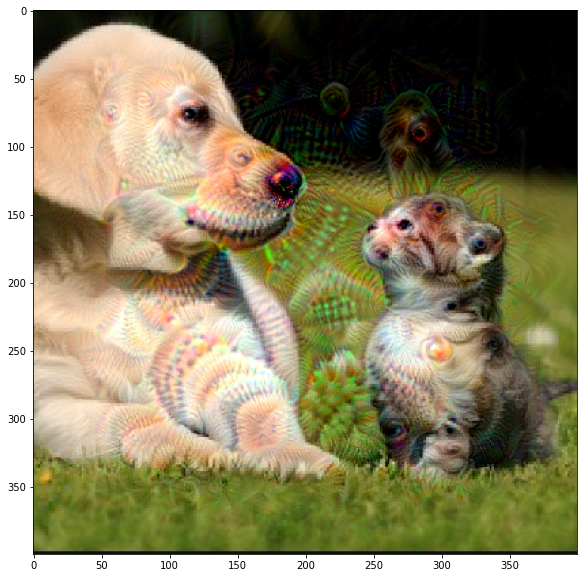

In [ ]:
plt.imshow(deprocess_image(img))